In [1]:
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt

## Optimization problem

We consider the ordinary least-squares problem (studied in the course) with the following notations:
\begin{eqnarray*}
A\in \mathbb{R}^{n\times d}, \quad x^* = 1\in \mathbb{R}^d, \quad b = Ax^*\\
f(x) =\frac{1}{2}\| Ax-b\|^2.
\end{eqnarray*}
Least-squares estimation amounts to finding a minimizer of $f$: $f^* =\min_x f(x) =0$.

In the course, we analyzed the gradient descent algorithm. Here we have:
\begin{eqnarray*}
\nabla f(x) = A^T(Ax-b),
\end{eqnarray*}
so that we can write the algorithm as:
\begin{eqnarray*}
x_0 &=& 0\\
x_{k+1} &=& x_k-\gamma A^T(Ax_k-b).
\end{eqnarray*}
The Hessian matrix $H = A^TA$ play a crucial role. $H$ belongs to the set of $d\times d$ symmetric matrices $\mathcal{S}_d$. We define $\mu=\lambda_{\min}(H)$ and $L=\lambda_\max(H)$ so that $\kappa=\frac{L}{\mu}$ is the condition number.

In the course, we showed the closed form expression:
\begin{eqnarray*}
x_{k+1} - x^* &=& x_k-x^* -\gamma A^T A(x_k-x^*)\\
x_{k+1} - x^* &=& \left( I- \gamma A^TA \right)(x_k-x^*)\\
&=& \left( I- \gamma H \right)^k(x_0-x^*).
\end{eqnarray*}
for $H x^* = A^Tb$ solution of $\nabla f(x) =0$. 

In [2]:
rng   = np.random.default_rng(1)
m   = 55
n   = 50
A   = rng.normal( size=(m,n) )
xStar = np.ones( (n,1) )
b   = A@xStar

f   = lambda x : norm(A@x-b)**2/2
grad= lambda x : A.T@( A@x-b )

fStar   = 0
x0      = np.zeros((n,1))

evals = np.linalg.eigvals(A.T@A)
L     = np.max(evals)
mu    = np.min(evals)
kappa = L/mu
print(f"L is {L:.2f}, mu is {mu:.2f}, condition number is {kappa:.2e}")

L is 204.96, mu is 0.17, condition number is 1.17e+03


In [3]:
def gradientDescent(f,grad,stepsize,x0,maxiter=1e3):
    x = x0.copy()
    fHist = []
    for k in range(int(maxiter)):
        x -= stepsize*grad(x)
        fHist.append( f(x) )
    return x, fHist

In [4]:
maxiter = 1e4
x_gd, fHist_gd  = gradientDescent(f,grad,1/L,x0,maxiter=maxiter)

x_gdopti, fHist_gdopti  = gradientDescent(f,grad,2/(L+mu),x0,maxiter=maxiter)

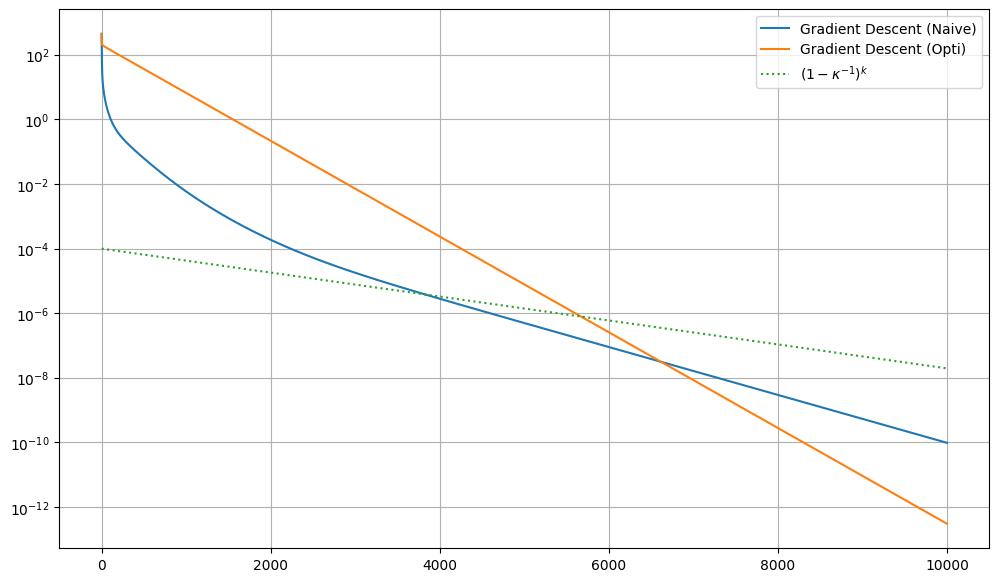

In [5]:
plt.figure(figsize=(12,7))
plt.semilogy( fHist_gd, label='Gradient Descent (Naive)' )
plt.semilogy( fHist_gdopti, label='Gradient Descent (Opti)' )
k = np.arange(1,maxiter)
plt.semilogy(k,1e-4*(1-1/kappa)**k,':',label='$(1-\\kappa^{-1})^{k}$')
plt.legend( loc='upper right')
plt.grid()
plt.show()

Code the Heavy Ball method:
$$x^{(k+1)} = x^{(k)} - \alpha \nabla f( x^{(k)}) + \beta (x^{(k)} - x^{(k-1)}) \qquad \text{ for some constants } \alpha>0, \beta\geq 0 . $$

In [6]:
def MomemtumGradientDescent(f,grad,stepsize,momentum,x0,maxiter=1e3):
    x = x0.copy()
    fHist = []
    diff = 0
    for k in range(int(maxiter)):
        xOld = x.copy()
        x = x - stepsize*grad(x)+ momentum*diff
        diff = (x-xOld)
        fHist.append( f(x) )
    return x, fHist

To compute the optimal choices for the stepsize and momentum $\alpha$ and $\beta$, we start by looking at the recursion:
\begin{eqnarray*}
\left(\begin{matrix}
x^{(k+1)}-x^*\\
x^{(k)}-x^*
\end{matrix}\right) &=& \left(\begin{matrix} x^{(k)} - \alpha \nabla f( x^{(k)}) + \beta (x^{(k)} - x^{(k-1)}) - x^*\\
x^{(k)}-x^*\end{matrix}\right)\\
&=& \left(\begin{matrix} (1+\beta)I -\alpha H & -\beta I\\
I & 0\end{matrix}\right)\left(\begin{matrix} x^{(k)}  - x^*\\
x^{(k-1)} -x^*\end{matrix}\right)
\end{eqnarray*}
To get a simpler matrix to analyze, we can "uncouple" the equations as follows: diagonalize $H = V\Lambda V^T$ with $VV^T=I$ and $\Lambda$ the diagonal matrix of the eigenvalues of $H$. Define $w^{(k)} = V^T(x^{(k)}-x^*)$ so that we get:
\begin{eqnarray*}
w^{(k+1)} = w^{(k)} - \alpha ( V^T Hx^{(k)} - V^T Hx^* ) +\beta ( V^T x^{(k)} - V^T x^{(k-1)}),
\end{eqnarray*}
and since $V^TH = \Lambda V^T$, we get:
\begin{eqnarray*}
w^{(k+1)} = ((1+\beta)-\alpha\Lambda) w^{(k)} -\beta w^{(k-1)}.
\end{eqnarray*}
For the $i$-th component of $w^{(k+1)}$, we need to look at the equation $u^2-(1+\beta-\alpha \lambda_i) u +\beta=0$ and make sure that the solutions have a module less than one. A necessary and sufficient condition is:
\begin{eqnarray*}
-1< &&\beta<1\\
0< &&\alpha \lambda_i <2+2\beta.
\end{eqnarray*}

Show that the choice $\alpha=\frac{4}{(\sqrt{L}+\sqrt{\ell})^2}$ and $\beta = \frac{\sqrt{L}-\sqrt{\ell}}{\sqrt{L}+\sqrt{\ell}}$ is valid and give the corresponding rate of convergence.

In [7]:
momentum = (np.sqrt(L)-np.sqrt(mu))**2/(np.sqrt(L)+np.sqrt(mu))**2
momentum

np.float64(0.8896901410167527)

In [8]:
step = 4/(np.sqrt(L)+np.sqrt(mu))**2
step

np.float64(0.018423462925653267)

What happens when momentum is too high? too low?

In [9]:
momentum = 0.99
x_m1gd, fHist_m1gd = MomemtumGradientDescent(f,grad,1/L,momentum,x0,maxiter=maxiter)
momentum = (np.sqrt(L)-np.sqrt(mu))**2/(np.sqrt(L)+np.sqrt(mu))**2
x_m2gd, fHist_m2gd = MomemtumGradientDescent(f,grad,step,momentum,x0,maxiter=maxiter)
momentum = 0.2
x_m3gd, fHist_m3gd = MomemtumGradientDescent(f,grad,1/L,momentum,x0,maxiter=maxiter)

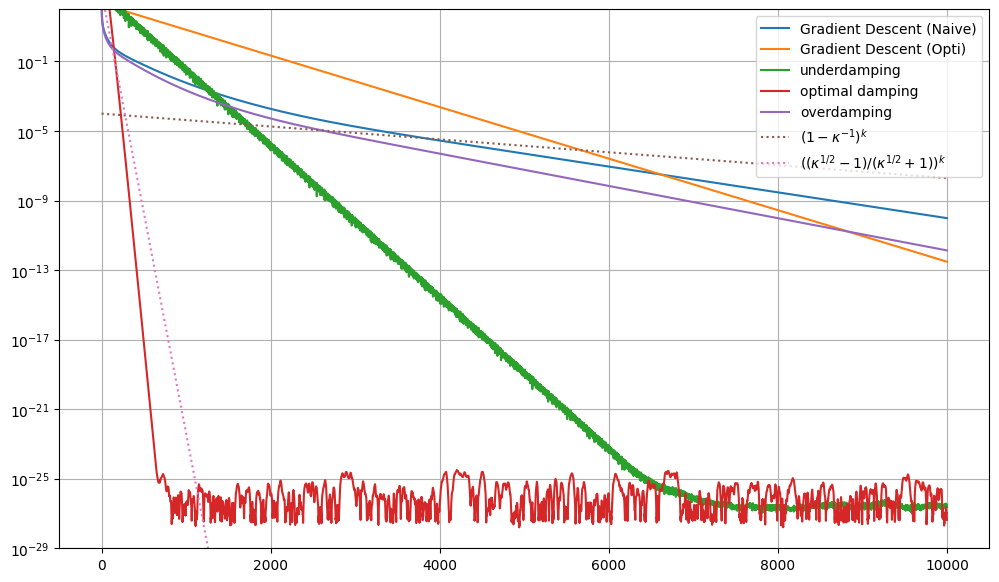

In [10]:
plt.figure(figsize=(12,7))
plt.semilogy( fHist_gd, label='Gradient Descent (Naive)' )
plt.semilogy( fHist_gdopti, label='Gradient Descent (Opti)' )
plt.semilogy( fHist_m1gd, label='underdamping' )
plt.semilogy( fHist_m2gd, label='optimal damping' )
plt.semilogy( fHist_m3gd, label='overdamping' )
k = np.arange(1,maxiter)
plt.semilogy(k,1e-4*(1-1/kappa)**k,':',label='$(1-\\kappa^{-1})^{k}$')
plt.semilogy(k,1e3*((np.sqrt(kappa)-1)/(np.sqrt(kappa)+1))**k,':',label='$((\\kappa^{1/2}-1)/(\\kappa^{1/2}+1))^{k}$')
plt.ylim(bottom=1e-29,top=1e2)
plt.legend( loc='upper right')
plt.grid()
plt.show()